# **TRABALHO DE DATA MINING - TURMA 23.1**

**PREVISÃO DE SOBREVIVÊNCIA DE CAVALOS COM BASE EM HISTÓRICO MÉDICO**  

\\
**Componentes do grupo:**  
Alexandre Koury - alexandrekoury@gmail.com  
Fabio Faria - fabiofaria2006@gmail.com  
Lara Teixeira - lssteixeira18@gmail.com  
Matheus Bernardes - matheusbnas@gmail.com  
Pedro Bethencourt - pedrobethencourt19@gmail.com

## **INTRODUÇÃO**

Este trabalho visa criar um modelo de classificação, supervisionado, que possa prever se um cavalo sobreviverá ou não com base nas condições médicas.

O dataset usado consiste de 27 atributos (numéricos e categóricos) que descrevem a saúde dos cavalos e de 3 classes de saída indicando se os cavalos nas amostras sobreviveram, morreram ou foram submetidos à eutanásia.

In [1]:
# Importação dos pacotes usados
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import missingno as msno
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# Seed para reprodução de resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

# Montando Google Drive no Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Carregando datasets de treino e de teste.
traindata = pd.read_csv('../data/horse.csv')
testdata = pd.read_csv('../data/horseTest.csv')

## **ANÁLISE EXPLORATÓRIA**

In [3]:
# @title
# Verificando as dimensões dos datasets de treino e de teste
print('Dimensões do dataset de treino:', traindata.shape)
print('Dimensões do dataset de teste:', testdata.shape)

Dimensões do dataset de treino: (299, 28)
Dimensões do dataset de teste: (89, 28)


### Iniciando análise exploratória da base de treino.

In [4]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

In [5]:
# @title
# Identificação dos atributos numéricos e categóricos

def identificar_tipos_atributos(df):
    tipos_atributos = df.dtypes
    atributos_numericos = tipos_atributos[tipos_atributos != 'object'].index
    atributos_categoricos = tipos_atributos[tipos_atributos == 'object'].index

    return {'numericos': list(atributos_numericos), 'categoricos': list(atributos_categoricos)}

tipos_atributos = identificar_tipos_atributos(traindata)

att_num = tipos_atributos['numericos']
att_cat = tipos_atributos['categoricos']

n_num = len(att_num)
num_cat = len(att_cat)

print(n_num, " Atributos Numéricos:")
print(att_num)

print("\n",num_cat, " Atributos Categóricos:")
print(att_cat)

11  Atributos Numéricos:
['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']

 17  Atributos Categóricos:
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'outcome', 'surgical_lesion', 'cp_data']


Temos **299** registros no dataset de treino e **89** no dataset de testes. Os datasets possuem **17** atributos categóricos e **11** numéricos. As classes de saída estão na coluna "**outcome**", que será portanto, a variável dependente.

Abaixo, iniciaremos a análise dos atributos numéricos.

In [6]:
traindata.describe().T

,count,mean,std,min,25%,50%,75%,max
hospital_number,299.0,1.087733e+06,1.532032e+06,518476.0,528904.0,530301.0,534736.00,5305629.0
rectal_temp,239.0,3.816862e+01,7.337444e-01,35.4,37.8,38.2,38.50,40.8
pulse,275.0,7.200000e+01,2.864622e+01,30.0,48.0,64.0,88.00,184.0
respiratory_rate,241.0,3.046058e+01,1.766610e+01,8.0,18.0,25.0,36.00,96.0
nasogastric_reflux_ph,53.0,4.707547e+00,1.982311e+00,1.0,3.0,5.0,6.50,7.5
packed_cell_volume,270.0,4.630741e+01,1.043674e+01,23.0,38.0,45.0,52.00,75.0
total_protein,266.0,2.427444e+01,2.736419e+01,3.3,6.5,7.5,56.75,89.0
abdomo_protein,101.0,3.039604e+00,1.967947e+00,0.1,2.0,2.3,3.90,10.1
lesion_1,299.0,3.659709e+03,5.408472e+03,0.0,2111.5,2322.0,3209.00,41110.0
lesion_2,299.0,9.052843e+01,6.506371e+02,0.0,0.0,0.0,0.00,7111.0


A coluna **hospital_number** é um identificador e como tal, não possui informações úteis que possam ser usadas para prever um resultado em um modelo de aprendizado de máquina, podendo inclusive causar *overfitting* devido à ordem de grandeza dos valores. Sua única utilidade seria identificar cavalos que possuem múltiplos registros médicos. Porém, há na base apenas 16 registros repetidos em um total de 299 (5% do conjunto de dados), conforme calculado abaixo.




In [7]:
# @title
# Calcular o número de registros repetidos do atributo hospital_number
registros_duplicados_hn =  traindata['hospital_number'].duplicated().sum()

# Imprimir o resultado
print("Número total de registros duplicados em hospital_number: ", registros_duplicados_hn)

Número total de registros duplicados em hospital_number:  16


Sendo assim, este atributo será eliminado no pré-processamento.

**lesion_1**, **lesion_2** e **lesion_3** requerem tratamento especial, pois apesar de serem numéricos, cada dígito representa o local e características de cada lesão. Voltaremos a eles mais a frente.

Agora analizaremos o percentual de dados faltantes para cada atributo.

In [8]:
# Percentual de valores faltantes por atributo na base de treino.
round(traindata.isnull().sum()/len(traindata)*100,2).sort_values(ascending=False)

nasogastric_reflux_ph    82.27
abdomo_protein           66.22
abdomo_appearance        55.18
abdomen                  39.46
nasogastric_reflux       35.45
nasogastric_tube         34.78
rectal_exam_feces        34.11
peripheral_pulse         23.08
rectal_temp              20.07
respiratory_rate         19.40
temp_of_extremities      18.73
abdominal_distention     18.73
pain                     18.39
mucous_membrane          15.72
peristalsis              14.72
total_protein            11.04
capillary_refill_time    10.70
packed_cell_volume        9.70
pulse                     8.03
lesion_2                  0.00
surgical_lesion           0.00
lesion_3                  0.00
lesion_1                  0.00
surgery                   0.00
outcome                   0.00
age                       0.00
hospital_number           0.00
cp_data                   0.00
dtype: float64

Há muitos atributos, tanto categóricos quanto numéricos, com valores faltantes. Mas antes de decidirmos a estratégia de tratamento, precisamos entender a correlação entre os atributos e a relevância de cada atributo em relação à saída.

Iniciaremos com a correlação entre os atributos numéricos.

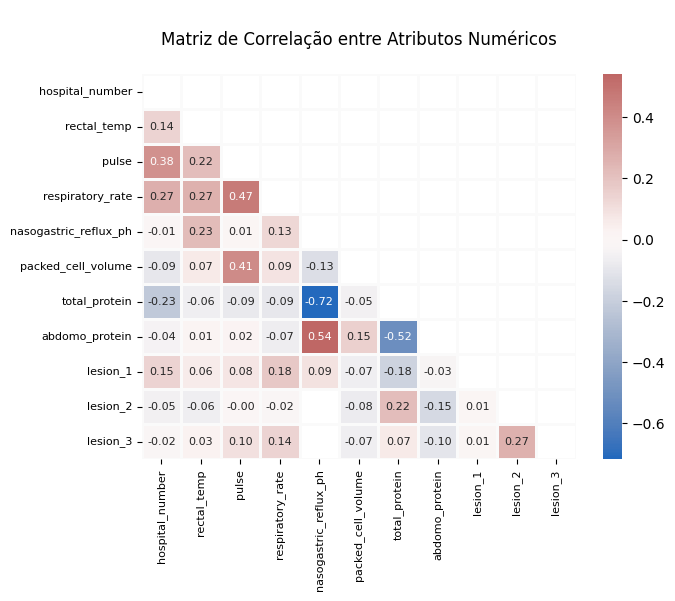

In [9]:
# @title
# Plotando a matriz de correlação dos atributos numéricos.
corr_matrix = traindata.select_dtypes(include=np.number).corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(7,5))

sns.heatmap(data=corr_matrix, mask=mask, cmap='vlag', linewidths=1, square=False, center=0.0, linecolor='#fafafa', annot=True, fmt=".2f", annot_kws={"size": 8})
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('\nMatriz de Correlação entre Atributos Numéricos\n', fontsize=12)
plt.show()

Há uma forte correlação entre os pares de atributos abaixo:

- *total_protein* e *nasogastric_reflux_ph*: **-0.72**
- *abdomo_protein* e *nasogastric_reflux_ph*: **0.54**
- *total_protein* e *abdomo_protein*: **-0.52**

Como visto anteriormente, ***abdomo_protein*** e ***nasogastric_reflux_ph*** também possuem os mais altos percentuais de dados faltantes do dataset.

Sendo assim, a fim de reduzirmos a multicolinearidade e evitarmos a inserção de muitos dados sintéticos no dataset, ***abdomo_protein*** e ***nasogastric_reflux_ph*** serão eliminados na fase de pré-processamento.

Agora, retornaremos à análise os atributos ***lesion_1***, ***lesion_2*** e ***lesion_3***.

In [10]:
# Contando valores repetidos em lesion_1, lesion_2 e lesion_3.
lesion_1_counts = traindata['lesion_1'].value_counts()
lesion_2_counts = traindata['lesion_2'].value_counts()
lesion_3_counts = traindata['lesion_3'].value_counts()

# Criando um dataframe com as contagens.
counts_df = pd.DataFrame({'lesion_1': lesion_1_counts, 'lesion_2': lesion_2_counts, 'lesion_3': lesion_3_counts})

# Imprimindo a quantidade de zeros em cada coluna.
counts_df[0:1]

,lesion_1,lesion_2,lesion_3
0,56,292.0,298.0


***lesion_2*** e ***lesion_3*** são predominantemente zero (ausência de lesão) e é bastante provável que não tenham significância em relação às classes de saída. Faremos o teste do Qui-Quadrado para confirmar essa hipótese.

Primeiro, criaremos listas de atributos categóricos e de atributos numéricos que serão úteis para o próximo gráfico e também no pré-processamento.

\\
* **outcome** é a variável dependente que estamos querendo inferir e, portanto, não será incluida na lista de atributos.

* Na lista de atributos categóricos, que chamaremos de **cat_atrib**, já incluiremos os atributos **lesion_2** e **lesion_3** devido às razões supracitadas.  

* O atributo **lesion_1** não será incluído na lista **cat_atrib** neste momento porque há uma grande variedade de combinações no dataframe que tornariam o gráfico a seguir ilegível. Esse atributo será tratado posteriormente.

* Na lista de atributos numéricos, que chamaremos de **num_atrib**, serão consideradas as colunas com tipo de dados diferente de *object*, excetuando os atributos **lesion_2** e **lesion_3**, pois estes serão tratados como categóricos.

In [11]:
# @title
# Lista de atributos categóricos.
cat_atrib = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane','capillary_refill_time','pain',
'peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen',
'abdomo_appearance','surgery', 'age', 'surgical_lesion', 'lesion_2', 'lesion_3', 'cp_data']

# Lista de atributos numéricos.
num_atrib = ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'lesion_1', 'abdomo_protein']

# Conferindo...
print('Número de atributos em cat_atrib:', len(cat_atrib))
print('Número de atributos em num_atrib:', len(num_atrib))

Número de atributos em cat_atrib: 18
Número de atributos em num_atrib: 9


Em seguida faremos uma análise visual dos atributos categóricos em relação às 3 classes de saída.

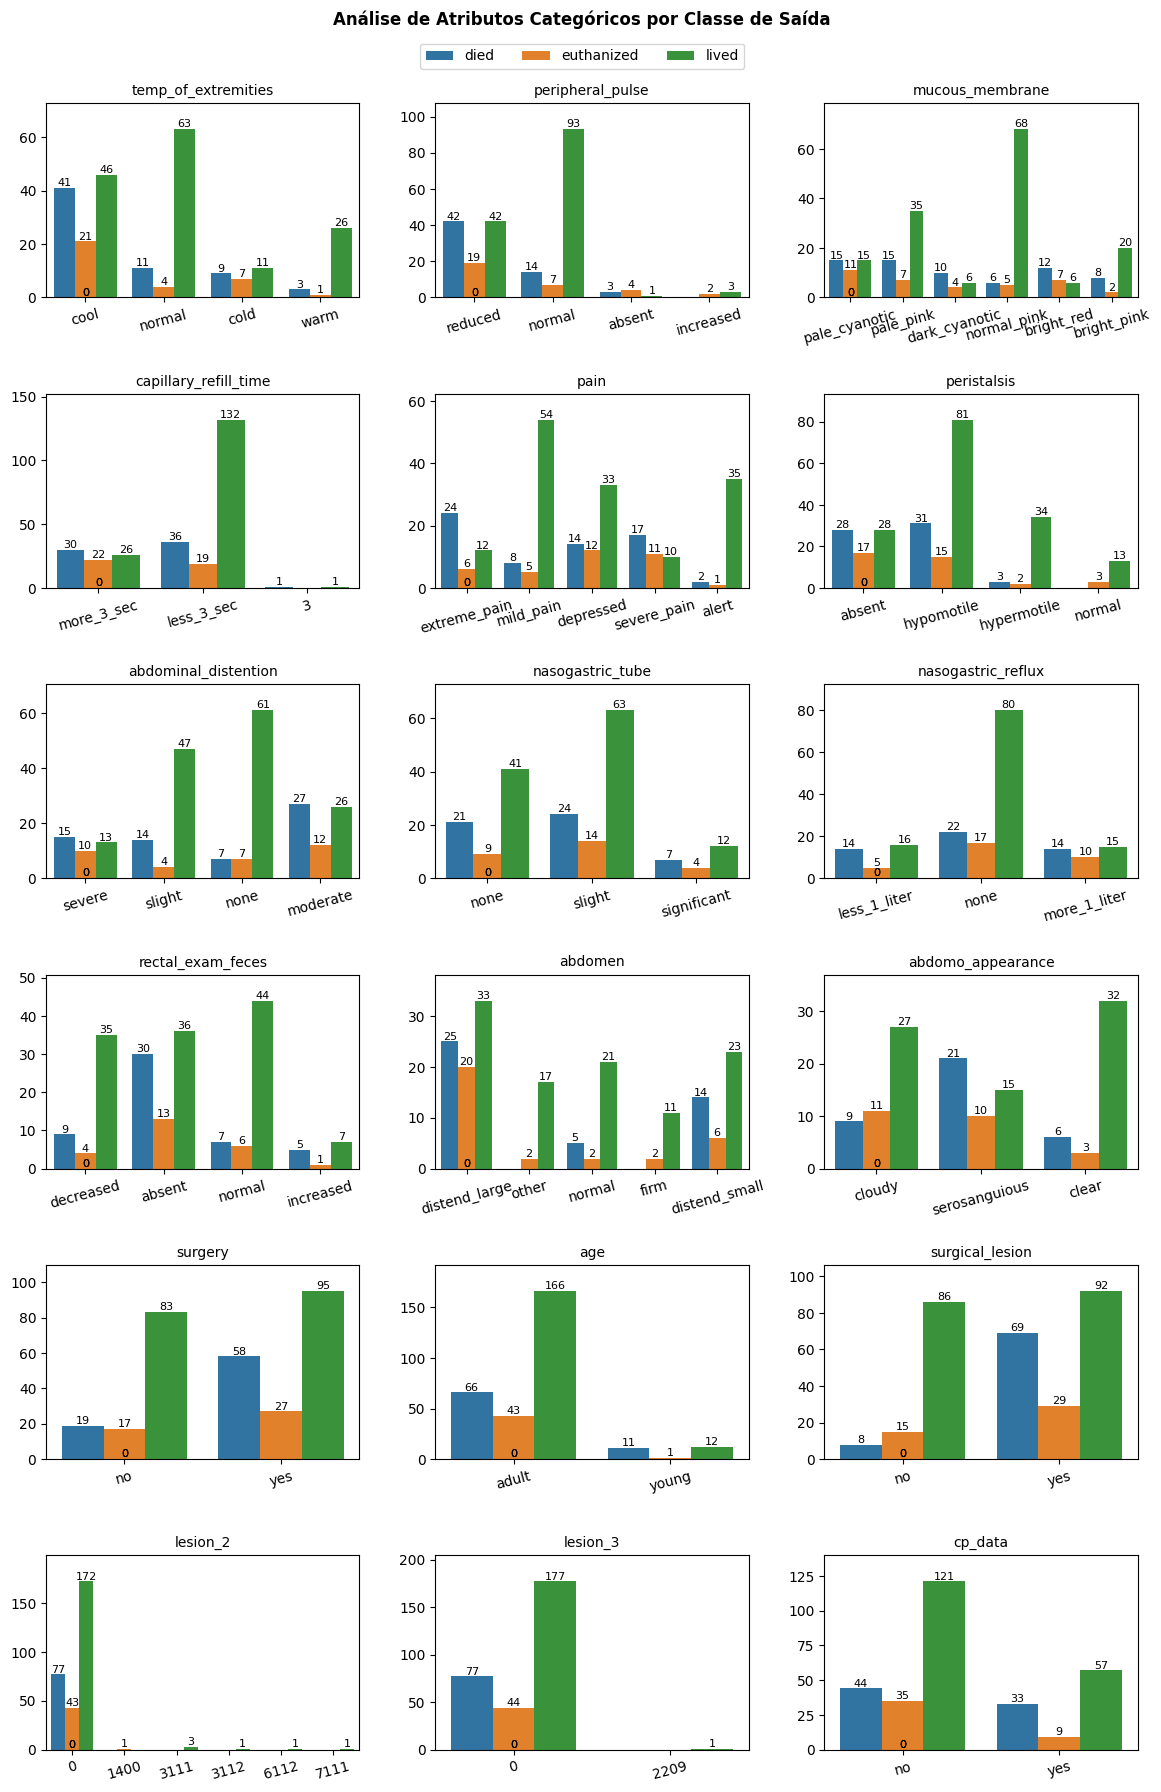

In [12]:
# @title
# Geração de gráficos de barras para exibir a distribuição de frequência
# das variáveis categóricas em cada classe de saída

# Função para gerar countplot
#   df: DataFrame com os dados
#   columns: Lista de colunas categóricas
#   n_cols: número de colunas de subplots
#   hue: classes de saída

def plot_count(df,columns,n_cols,hue):
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],hue=hue)

        # Titles
        ax[i].set_title(f'{column}', fontsize=10)
        ax[i].set_xlabel(None, fontsize=10)
        ax[i].set_ylabel(None, fontsize=10)
        ax[i].tick_params(axis='x', rotation=15)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=8)

        ylim_top = ax[i].get_ylim()[1]
        ax[i].set_ylim(top=ylim_top * 1.1)

        # Remove the legend for each subplot
        ax[i].get_legend().remove()

    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    # Add a single legend for all subplots
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.985), ncol=len(handles))

    fig.suptitle('Análise de Atributos Categóricos por Classe de Saída', fontsize=12, fontweight='bold', y=1)
    plt.tight_layout(pad=2)
    plt.show()

plot_count(traindata,cat_atrib,3,'outcome')

Alguns atributos categóricos são ordinais, possuem valores que seguem uma classificação. Outros atributos são nominais ou binários e não possuem ordem. Adotaremos técnicas de encoding diferentes para cada tipo de atributo no pré-processamento.  

Para a coluna ***pain***, apesar de parecer ordinal, a documentação do dataset indica tratá-lo como um atributo nominal. Porque, além de ser um avaliação subjetiva para o nível de dor, tratamentos para controle da dor administrados anteriormente podem mascarar a dor real que o animal está sentindo.

Também podemos inferir dos gráficos acima que ***nasogastric_tube*** parece não influenciar a saída, porque, independente de qual tenha sido a avaliação desse parâmetro, a proporção de cavalos que sobreviveram, ou morreram, ou que sofreram eutanásia praticamente não muda. Isso fica mais claro no gráfico abaixo.

outcome               died  euthanized     lived
nasogastric_tube                                
none              0.295775    0.126761  0.577465
significant       0.304348    0.173913  0.521739
slight            0.237624    0.138614  0.623762 



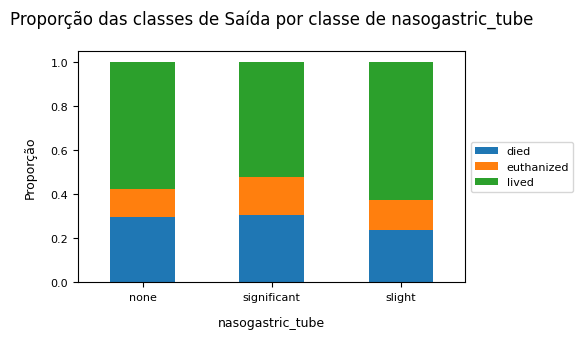

In [13]:
# @title
# Calcular a proporção das classes de saída em relação ao atributo nasogastric_tube
proporcao_classes = pd.crosstab(traindata['nasogastric_tube'], traindata['outcome'], normalize='index')

print(proporcao_classes, "\n")


# Plotar o gráfico de barras empilhadas
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(5, 3))

proporcao_classes.plot(kind='bar', stacked=True, ax=ax)

plt.title('Proporção das classes de Saída por classe de nasogastric_tube', fontsize=12, pad=20)
ax.set_xlabel('nasogastric_tube', labelpad=10, fontsize=9)
ax.set_ylabel('Proporção', labelpad=10, fontsize=9)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)


plt.show()

Aplicaremos o teste Qui-Quadrado para identificar significância dos atributos categóricos em relação às classes de saída.

Usaremos o valor P para avaliar se cada variável categórica possui uma associação estatisticamente significativa com a variável alvo (**outcome**). Se o valor P for menor que 0,05, podemos dizer que há uma relação estatisticamente significativa. Caso contrário, não é possível concluir que essas variáveis tenham relação.

In [14]:
# @title
# Aplicação do teste Qui-Quadrado
from scipy import stats

def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)

    if p < significance_level:
        print(f'\033[32m{input_var} tem uma associação estatisticamente significativa com a variável alvo.\033[0m')
    else:
        print(f'\033[31m{input_var} não tem uma relação estatisticamente significativa com a variável alvo.\033[0m')

for i in cat_atrib:
    chi_squared_test(traindata, i, 'outcome')

temp_of_extremities tem uma associação estatisticamente significativa com a variável alvo.
peripheral_pulse tem uma associação estatisticamente significativa com a variável alvo.
mucous_membrane tem uma associação estatisticamente significativa com a variável alvo.
capillary_refill_time tem uma associação estatisticamente significativa com a variável alvo.
pain tem uma associação estatisticamente significativa com a variável alvo.
peristalsis tem uma associação estatisticamente significativa com a variável alvo.
abdominal_distention tem uma associação estatisticamente significativa com a variável alvo.
nasogastric_tube não tem uma relação estatisticamente significativa com a variável alvo.
nasogastric_reflux tem uma associação estatisticamente significativa com a variável alvo.
rectal_exam_feces tem uma associação estatisticamente significativa com a variável alvo.
abdomen tem uma associação estatisticamente significativa com a variável alvo.
abdomo_appearance tem uma associação estati

Os atributos ***nasograstric_tube***, ***lesion_2*** e ***lesion_3*** não têm relação significativa com as classes de saída. Como esse resultado corrobora com as demais análises feitas ao longo desta análise exploratória, esses atributos serão removidos no pré-processamento.

Vamos analisar a necessidade de balanceamento do dataset.

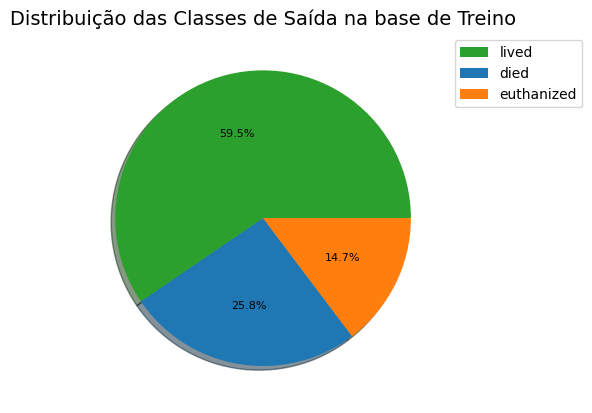

<Figure size 500x500 with 0 Axes>

In [15]:
# @title
# Verificando a distribuição de amostras entre as 3 classes de saída na base de treino.
target_dist = traindata['outcome'].value_counts()

# Usando as mesmas cores do gráfico anterior para cada saída.
color_dict = {"died": "tab:blue", "euthanized": "tab:orange", "lived": "tab:green"}
colors = [color_dict[i] for i in target_dist.index]

plt.pie(target_dist, shadow=True, autopct='%.1f%%', colors=colors)
plt.title('Distribuição das Classes de Saída na base de Treino', size=14)
plt.legend(target_dist.index, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.figure(figsize=(5,5))
plt.show()

A base está um pouco desbalanceada. Testaremos o desempenho do modelo com três abordagens: sem criar dados sintéticos, criando dados sintéticos para equilibrar as classes (*oversampling*) e eliminando registros da classe majoritária (*undersampling*).

## **PRÉ-PROCESSAMENTO**

### Remoção de Atributos Desnecessários

Nesta etapa, descartaremos os atributos que, na análise exploratória, apresentaram:

*   Muitos dados faltantes;
*   Não ter relação significativa com a saída;
*   Muita correlação com outros atributos (multicolinearidade)

\\
Os atributos são:  
* *lesion_2*  
* *lesion_3*  
* *abdomo_protein*  
* *nasogastric_tube*  
* *nasogastric_reflux_ph*  
* *hospital_number*

Além dos listados acima, identificados durante a análise exploratória, algumas outras colunas do conjunto de dados também precisarão ser descartadas.

* O atributo **cp_data** informa se dados patolóticos foram coletados para cada caso. No entanto, tais dados não estão contidos no dataset e, portanto, a variável **cp_data** é irrelevante.

* Inicialmente, o atributo **lesion_1** havia sido incluido no treinamento como um dado numérico devido a dificuldade de codificá-lo adequadamente. Isso, porque alguns dos 4 elementos que compõem **lesion_1** possuem representações de 1 e de 2 dígitos cada, sendo esta a razão porque esse atributo tem de 1 a 5 dígitos no total.

* Entretanto, todos os modelos tiveram desempenho superior quando treinados sem o atributo, exceto Random Forest que, por já possuir seletor de atributos embutido, não teve variação de desempenho. Logo, concluímos que o atributo **lesion_1** não tem importância significativa para este modelo de previsão e também será descartado.

Também separaremos as saídas das entradas tanto do dataset de treino quanto do dataset de teste.

In [16]:
# Colunas a remover
att_to_remove = ['hospital_number', 'lesion_1', 'outcome', 'lesion_2', 'lesion_3','abdomo_protein','nasogastric_tube','nasogastric_reflux_ph','cp_data']

# Dividindo o dataset de treino em entradas (x_train) e saída (y_train).
x_train = traindata.drop(columns=att_to_remove)
y_train = traindata[['outcome']]

# Dividindo o dataset de teste em entrada (x_test) e saída (y_test)
x_test = testdata.drop(columns=att_to_remove)
y_test = testdata[['outcome']]

In [17]:
# @title
#Verificando shape de cada dataset
print('Dimensões do conjunto de entradas de treino:', x_train.shape)
print('Dimensões do conjunto de saída de treino:', y_train.shape)
print('Dimensões do conjunto de entradas de teste:', x_test.shape)
print('Dimensões do conjunto de saída de teste:', y_test.shape)

Dimensões do conjunto de entradas de treino: (299, 19)
Dimensões do conjunto de saída de treino: (299, 1)
Dimensões do conjunto de entradas de teste: (89, 19)
Dimensões do conjunto de saída de teste: (89, 1)


Tínhamos 27 atributos no dataset original. Agora temos 19.

### Tratamento de Dados Faltantes

Nesta etapa, trataremos os valores faltantes nas bases de treino e de teste.

Completaremos os valores categóricos faltantes com os valores mais frequentes e as colunas numéricas, com a mediana.

In [18]:
# Criando novas listas de atributos numéricos e categóricos.
num_atrib_new = [item for item in num_atrib if item not in att_to_remove]
cat_atrib_new = [item for item in cat_atrib if item not in att_to_remove]

print("Atributos numéricos:", num_atrib_new)
print("Atributos Categóricos:", cat_atrib_new)

Atributos numéricos: ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']
Atributos Categóricos: ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgery', 'age', 'surgical_lesion']


**VISUALIZAÇÃO DAS BASES ANTES DO TRATAMENTO**

**Base de treino**

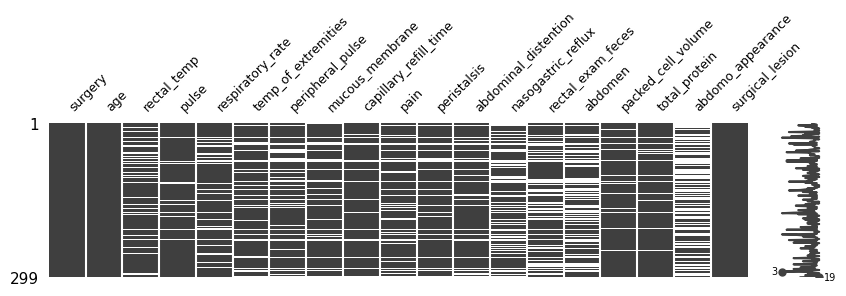

In [19]:
# Verificação gráfica de existência de missing values na base de treino.
msno.matrix(x_train, figsize=(10,2), fontsize=9);

**Base de teste**

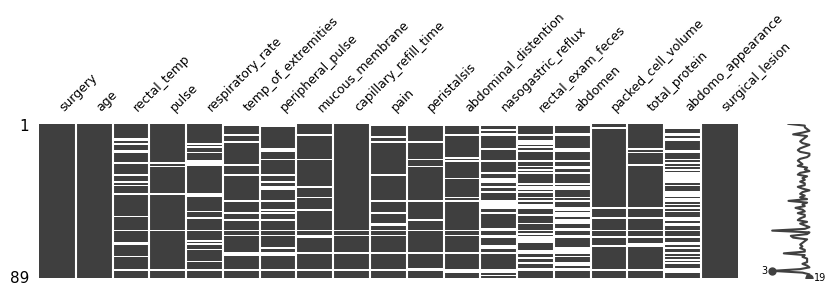

In [20]:
# Verificação gráfica de existência de missing values na base de teste.
msno.matrix(x_test, figsize=(10,2), fontsize=9);

Calcularemos a mediana de cada coluna numérica e aplicaremos o resultado tanto na base de treino quanto na de teste.

In [21]:
# Calculando medianas dos atributos numéricos.
median_train = x_train[num_atrib_new].median()

median_train

rectal_temp           38.2
pulse                 64.0
respiratory_rate      25.0
packed_cell_volume    45.0
total_protein          7.5
dtype: float64

In [22]:
# Completando valores numéricos faltantes com a mediana.
x_train[num_atrib_new] = x_train[num_atrib_new].fillna(median_train)

# Completando os valores numéricos faltantes na base de testes com as medianas calculadas na base de treino.
x_test[num_atrib_new] = x_test[num_atrib_new].fillna(median_train)

Processo similar será aplicado às colunas categóricas, agora usando a moda.

In [23]:
# Calculando a moda das colunas categóricas da base de treino.
mode_train = x_train[cat_atrib_new].mode()
mode_train.loc[0,:]

temp_of_extremities               cool
peripheral_pulse                normal
mucous_membrane            normal_pink
capillary_refill_time       less_3_sec
pain                         mild_pain
peristalsis                 hypomotile
abdominal_distention              none
nasogastric_reflux                none
rectal_exam_feces               absent
abdomen                  distend_large
abdomo_appearance               cloudy
surgery                            yes
age                              adult
surgical_lesion                    yes
Name: 0, dtype: object

In [24]:
# Aplicando a moda na base de treino
for i in cat_atrib_new:
  mode = mode_train.loc[0,i]
  x_train[i].fillna(mode, inplace = True)

# Aplicando a moda na base de teste
for i in cat_atrib_new:
  mode = mode_train.loc[0,i]
  x_test[i].fillna(mode, inplace = True)

**VISUALIZAÇÃO APÓS TRATAMENTO**

Verificando se todos os valores faltantes foram tratados.

**Base de treino**

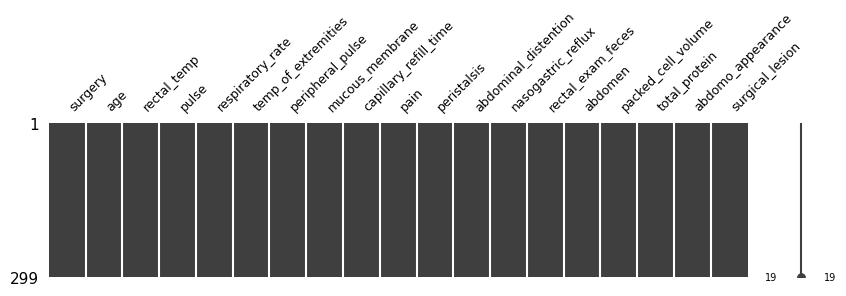

In [25]:
# Verificação gráfica de existência de missing values na base de treino
msno.matrix(x_train,figsize=(10,2), fontsize=9);

**Base de teste**

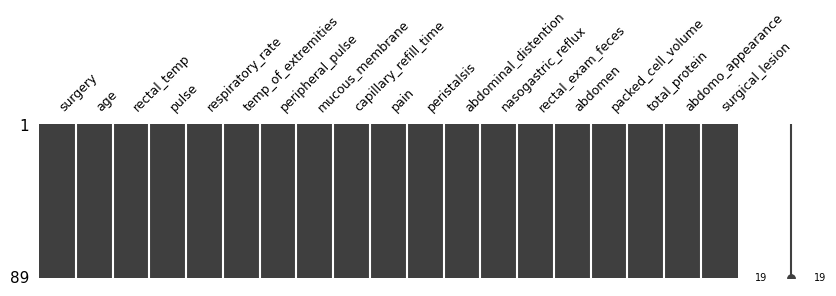

In [26]:
# Verificação gráfica de existência de missing values na base de teste
msno.matrix(x_test, figsize=(10,2), fontsize=9);

### Normalização

Com *missing values* tratados, precisamos normalizar os atributos numéricos. Alguns dos algoritmos de treinamento que pretendemos utilizar são sensíveis a dados não-normalizados.  

Testaremos 3 algoritmos de normalização (StandardScaler, RobustScaler e MinMaxScaler) para verificar qual é o mais adequado para a nossa base.

In [27]:
# Testando o desempenho de três normalizadores
std_scaler = StandardScaler().fit(x_train[num_atrib_new])
rob_scaler = RobustScaler().fit(x_train[num_atrib_new])
mm_scaler = MinMaxScaler().fit(x_train[num_atrib_new])

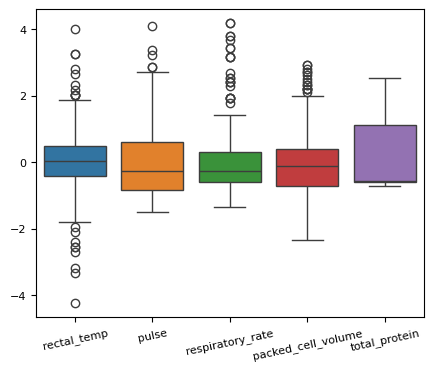

In [28]:
# Standard Scaler
x_train_std = x_train.copy()
x_train_std[num_atrib_new] = std_scaler.transform(x_train[num_atrib_new])
plt.figure(figsize=(5, 4))
sns.boxplot(x_train_std[num_atrib_new])
plt.xticks(rotation=12)
plt.show()

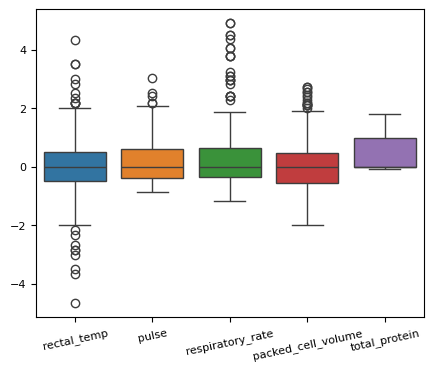

In [29]:
# RobustScaler
x_train_rob = x_train.copy()
x_train_rob[num_atrib_new] = rob_scaler.transform(x_train[num_atrib_new])
plt.figure(figsize=(5, 4))
sns.boxplot(x_train_rob[num_atrib_new])
plt.xticks(rotation=12)
plt.show()

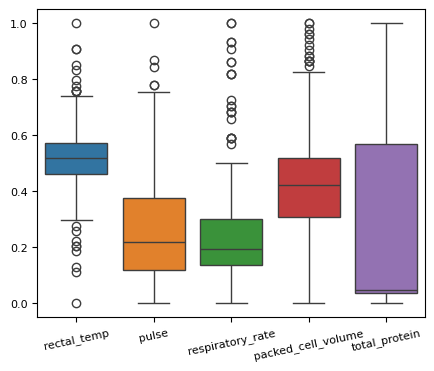

In [30]:
# MinMaxScaler
x_train_mm = x_train.copy()
x_train_mm[num_atrib_new] = mm_scaler.transform(x_train[num_atrib_new])
plt.figure(figsize=(5, 4))
sns.boxplot(x_train_mm[num_atrib_new])
plt.xticks(rotation=12)
plt.show()

*RobustScaler* parece mais adequado, pois foi o que melhor minimizou o efeito dos outliers. Aplicaremos a mesma transformação na base de teste.

In [31]:
# Aplicando a normalização sobre as bases de treino e teste:

X_train_scaled = x_train.copy()
X_test_scaled = x_test.copy()
X_train_scaled[num_atrib_new] = rob_scaler.transform(X_train_scaled[num_atrib_new])
X_test_scaled[num_atrib_new] = rob_scaler.transform(X_test_scaled[num_atrib_new])

### Conversão de Atributos Categóricos em Numéricos


Como comentado anteriormente, os atributos categóricos serão convertidos para numéricos usando técnicas diferentes de enconding para cada caso.

\\
**Atributos Ordinais (*label encoding*):**  
*temp_of_extremities*  
*peristalsis*  
*abnominal_distention*  
*peripheral_pulse*  
*rectal_exam_feces*  
*surgery*  
*surgical_lesion*

In [32]:
# Criando lista de colunas a aplicar Label Encoding.
cat_label_encoding = ["temp_of_extremities", "peristalsis", "abdominal_distention", "peripheral_pulse", "rectal_exam_feces", "surgery", "surgical_lesion"]

# Função para aplicar Label Encoding e armazenar os mapeamentos
def apply_label_encoding(df_train, df_test, columns):
    label_encoder = LabelEncoder()
    mappings_train = {}
    mappings_test = {}
    for column in columns:
        df_train[column] = label_encoder.fit_transform(df_train[column])
        mappings_train[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        df_test[column] = label_encoder.transform(df_test[column])
        mappings_test[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    return mappings_train, mappings_test

# Aplica o Label Encoding e armazena os mapeamentos
mappings_train, mappings_test = apply_label_encoding(X_train_scaled, X_test_scaled, cat_label_encoding)


In [33]:
# @title Conferindo o resultado do label encoding.
# Cria um DataFrame para cada mapeamento
df_train = pd.DataFrame(list(mappings_train.items()), columns=['Coluna', 'Mapeamento na base de treino'])
df_test = pd.DataFrame(list(mappings_test.items()), columns=['Coluna', 'Mapeamento na base de teste'])

# Combina os DataFrames
df = pd.merge(df_train, df_test, on='Coluna')

# Define a coluna 'Column' como o índice
df.set_index('Coluna', inplace=True)

# Imprime o DataFrame
pd.set_option('display.max_colwidth', None)
df

,Mapeamento na base de treino,Mapeamento na base de teste
Coluna,,
temp_of_extremities,"{'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3}","{'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3}"
peristalsis,"{'absent': 0, 'hypermotile': 1, 'hypomotile': 2, 'normal': 3}","{'absent': 0, 'hypermotile': 1, 'hypomotile': 2, 'normal': 3}"
abdominal_distention,"{'moderate': 0, 'none': 1, 'severe': 2, 'slight': 3}","{'moderate': 0, 'none': 1, 'severe': 2, 'slight': 3}"
peripheral_pulse,"{'absent': 0, 'increased': 1, 'normal': 2, 'reduced': 3}","{'absent': 0, 'increased': 1, 'normal': 2, 'reduced': 3}"
rectal_exam_feces,"{'absent': 0, 'decreased': 1, 'increased': 2, 'normal': 3}","{'absent': 0, 'decreased': 1, 'increased': 2, 'normal': 3}"
surgery,"{'no': 0, 'yes': 1}","{'no': 0, 'yes': 1}"
surgical_lesion,"{'no': 0, 'yes': 1}","{'no': 0, 'yes': 1}"


**Atributos Nominais ou Binários (*Dummy Encoding*):**  
*capillary_refill_time*  
*pain*  
*mucous_membrane*  
*nasogastric_reflux*  
*abdomen*  
*abdomo_appearance*  
*age*

In [34]:
# @title
# Criando lista de colunas a aplicar Dummy Enconding.
cat_dummy_encoding = ["capillary_refill_time", "pain", "mucous_membrane", "nasogastric_reflux", "abdomen", "abdomo_appearance", "age"]

# Função para contar valores únicos em colunas de um dataset.
def count_unique_values(df, columns):
    unique_counts = {}
    for column in columns:
        unique_counts[column] = df[column].nunique()
    return unique_counts

#cat_dummy_encoding = ["capillary_refill_time", "pain", "mucous_membrane", "nasogastric_reflux", "abdomen", "abdomo_appearance", "age"]
unique_counts = count_unique_values(X_train_scaled, cat_dummy_encoding)

print("Quantidade de valores discretos nas colunas nominais/binárias:")
print(unique_counts)


Quantidade de valores discretos nas colunas nominais/binárias:
{'capillary_refill_time': 3, 'pain': 5, 'mucous_membrane': 6, 'nasogastric_reflux': 3, 'abdomen': 5, 'abdomo_appearance': 3, 'age': 2}


In [35]:
# Dummy Encoding dos atributos Nominais e binários.

# Aplicando Dummy Encoding no conjunto de treino.
dummies_train = pd.get_dummies(X_train_scaled[cat_dummy_encoding], drop_first=True).astype(int)

# Aplicando Dummy Encoding no conjunto de teste.
dummies_test = pd.get_dummies(X_test_scaled[cat_dummy_encoding], drop_first=True).astype(int)

Para Dummy Enconding, usamos o parâmetro ***drop_first=True*** para não aumentarmos a dimensão do nosso dataset além do necessário.  

No total, ficaremos com 13 colunas a mais nos datasets de treino e de teste, totalizando 32 colunas. Vamos conferir.

In [36]:
# Mesclando as colunas resultantes do Dummy Encoding no conjunto de treino.
X_train_scaled = pd.concat([dummies_train,X_train_scaled],axis=1)

# Eliminando as colunas originais que sofreram Dummy Encoding.
X_train_scaled = X_train_scaled.drop(columns=cat_dummy_encoding)

# Verificando o resultado no conjunto de treino.
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   capillary_refill_time_less_3_sec  299 non-null    int32  
 1   capillary_refill_time_more_3_sec  299 non-null    int32  
 2   pain_depressed                    299 non-null    int32  
 3   pain_extreme_pain                 299 non-null    int32  
 4   pain_mild_pain                    299 non-null    int32  
 5   pain_severe_pain                  299 non-null    int32  
 6   mucous_membrane_bright_red        299 non-null    int32  
 7   mucous_membrane_dark_cyanotic     299 non-null    int32  
 8   mucous_membrane_normal_pink       299 non-null    int32  
 9   mucous_membrane_pale_cyanotic     299 non-null    int32  
 10  mucous_membrane_pale_pink         299 non-null    int32  
 11  nasogastric_reflux_more_1_liter   299 non-null    int32  
 12  nasogast

In [37]:
# Mesclando as colunas resultantes do Dummy Encoding no conjunto de teste.
X_test_scaled = pd.concat([dummies_test,X_test_scaled],axis=1)

# Eliminando as colunas originais que sofreram Dummy Encoding.
X_test_scaled = X_test_scaled.drop(columns=cat_dummy_encoding)

# Verificando o resultado no conjunto de treino.
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   capillary_refill_time_less_3_sec  89 non-null     int32  
 1   capillary_refill_time_more_3_sec  89 non-null     int32  
 2   pain_depressed                    89 non-null     int32  
 3   pain_extreme_pain                 89 non-null     int32  
 4   pain_mild_pain                    89 non-null     int32  
 5   pain_severe_pain                  89 non-null     int32  
 6   mucous_membrane_bright_red        89 non-null     int32  
 7   mucous_membrane_dark_cyanotic     89 non-null     int32  
 8   mucous_membrane_normal_pink       89 non-null     int32  
 9   mucous_membrane_pale_cyanotic     89 non-null     int32  
 10  mucous_membrane_pale_pink         89 non-null     int32  
 11  nasogastric_reflux_more_1_liter   89 non-null     int32  
 12  nasogastri

Ainda precisamos codificar a saída. Atribuiremos:

* lived = 2  
* died = 1  
* euthanized = 0

\\
Antes da codificação:

In [38]:
# @title
# Cria um DataFrame para comparar os valores antes da codificação da saída
df = pd.DataFrame({
    'y_train': y_train.outcome.value_counts(),
    'y_test': y_test.outcome.value_counts()
})

# Imprime o DataFrame
df

,y_train,y_test
outcome,,
lived,178,53
died,77,23
euthanized,44,13


In [39]:
import warnings
warnings.filterwarnings('ignore')

# Encoding do output
def encode_output(value):
  if value == "lived": return 2
  if value == "died": return 1
  if value == "euthanized": return 0

y_train.outcome = y_train.outcome.apply(encode_output)
y_test.outcome = y_test.outcome.apply(encode_output)

Depois da codificação:

In [40]:
# @title
# Cria um DataFrame para comparar os valores
df = pd.DataFrame({
    'y_train': y_train.outcome.value_counts(),
    'y_test': y_test.outcome.value_counts()
})

# Imprime o DataFrame
df

,y_train,y_test
outcome,,
2,178,53
1,77,23
0,44,13


### Balanceamento

Como mencionado anteriormente, testaremos o modelo com a base desbalanceada, com oversampling e com undersampling.

\\
Abaixo criaremos dataframes para cada caso.

In [41]:
# outcome antes do balanceamento
y_train.value_counts(normalize=False)

outcome
2          178
1           77
0           44
Name: count, dtype: int64

In [42]:
# @title Undersampling
# Undersampling aleatório da classe 2 ('lived').

# Encontrando os índices das linhas da classe majoritária
indices = y_train[y_train['outcome'] == 2].index

# Selecionando 78 índices
random_indices = np.random.choice(indices, size=min(78, len(indices)), replace=False)

# Remove essas linhas do dataframe
X_train_scaled_usamp = X_train_scaled.drop(random_indices)
y_train_usamp = y_train.drop(random_indices)

In [43]:
y_train_usamp.value_counts(normalize=False)

outcome
2          100
1           77
0           44
Name: count, dtype: int64

O undersampling removeu aleatoriamente 78 colunas da classe majoritária, tornando a base mais balanceada.

In [44]:
# @title Oversampling
# Oversampling com SMOTE
smote = SMOTE(n_jobs=-1, k_neighbors=3)
X_train_scaled_osamp, y_train_osamp = smote.fit_resample(X_train_scaled, y_train)

In [45]:
# Conferindo o resultado do oversampling
y_train_osamp.value_counts(normalize=False)

outcome
0          178
1          178
2          178
Name: count, dtype: int64

O oversampling criou dados sintéticos das classes minoritárias "died" e "euthanized", fazendo-as ficar na mesma proporção da classe majoritária "lived".

## **MACHINE LEARNING**

Vamos comparar o desempenho de modelos treinandos com 4 algoritmos diferentes:

* Random Forest (RF)
* Logistic Regression (LR)
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

\\
Todos os modelos foram treinados e validados nas bases desbalanceadas, nas bases com undersampling e nas bases com oversampling.


### Treinamento dos modelos

In [46]:
# Treinando os modelos na base sem balanceamento
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=10)
lr = LogisticRegression(max_iter=200)
svm = SVC()
knn = KNeighborsClassifier(n_neighbors=3)

rf.fit(X_train_scaled,y_train.values.ravel())
lr.fit(X_train_scaled,y_train.values.ravel())
svm.fit(X_train_scaled,y_train.values.ravel())
knn.fit(X_train_scaled,y_train.values.ravel())

# Treinando os modelos na base com undersampling
rf_usamp = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=10)
lr_usamp = LogisticRegression(max_iter=200)
svm_usamp = SVC()
knn_usamp = KNeighborsClassifier(n_neighbors=3)

rf_usamp.fit(X_train_scaled_usamp,y_train_usamp.values.ravel())
lr_usamp.fit(X_train_scaled_usamp,y_train_usamp.values.ravel())
svm_usamp.fit(X_train_scaled_usamp,y_train_usamp.values.ravel())
knn_usamp.fit(X_train_scaled_usamp,y_train_usamp.values.ravel())

# Treinando os modelos na base com oversampling
rf_osamp = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=10)
lr_osamp = LogisticRegression(max_iter=200)
svm_osamp = SVC()
knn_osamp = KNeighborsClassifier(n_neighbors=3)

rf_osamp.fit(X_train_scaled_osamp,y_train_osamp.values.ravel())
lr_osamp.fit(X_train_scaled_osamp,y_train_osamp.values.ravel())
svm_osamp.fit(X_train_scaled_osamp,y_train_osamp.values.ravel())
knn_osamp.fit(X_train_scaled_osamp,y_train_osamp.values.ravel())

KNeighborsClassifier(n_neighbors=3)

Para os modelos treinados com *Random Forest*, ativamos a gravação do *OOB (Out of Bag) Score*. O *OOB Score* nos ajudará a identificar sinais de *overfitting* nos modelos, caso ocorra.

Os demais hiperparâmetros foram os que apresentaram os melhores resultados na validação cruzada.

### Validação cruzada

Usaremos a função *cross_validate()* do *scikit-learn* para realizar a validação cruzada nos modelos treinados. Como a base de treino não é muito grande, esperamos que 5 partições sejam suficientes para detectarmos *overfitting*.

In [47]:
# Fazendo validação cruzada com cross_validate

# Na base sem balanceamento, fazendo cv com 5 folds
scores_rf = cross_validate(rf,X_train_scaled, y_train.values.ravel(), cv=5)
scores_lr = cross_validate(lr,X_train_scaled, y_train.values.ravel(), cv=5)
scores_svm = cross_validate(svm,X_train_scaled, y_train.values.ravel(), cv=5)
scores_knn = cross_validate(knn,X_train_scaled, y_train.values.ravel(), cv=5)

In [48]:
# Na base com undersampling, fazendo cv com 5 folds
scores_rf_usamp = cross_validate(rf_usamp,X_train_scaled_usamp, y_train_usamp.values.ravel(), cv=5)
scores_lr_usamp = cross_validate(lr_usamp,X_train_scaled_usamp, y_train_usamp.values.ravel(), cv=5)
scores_svm_usamp = cross_validate(svm_usamp,X_train_scaled_usamp, y_train_usamp.values.ravel(), cv=5)
scores_knn_usamp = cross_validate(knn_usamp,X_train_scaled_usamp, y_train_usamp.values.ravel(), cv=5)

In [49]:
# Na base com oversampling, fazendo cv com 5 folds
scores_rf_osamp = cross_validate(rf_osamp,X_train_scaled_osamp, y_train_osamp.values.ravel(), cv=5)
scores_lr_osamp = cross_validate(lr_osamp,X_train_scaled_osamp, y_train_osamp.values.ravel(), cv=5)
scores_svm_osamp = cross_validate(svm_osamp,X_train_scaled_osamp, y_train_osamp.values.ravel(), cv=5)
scores_knn_osamp = cross_validate(knn_osamp,X_train_scaled_osamp, y_train_osamp.values.ravel(), cv=5)

A função *cross_validate()*, por padrão, avalia o modelo calculando a acurácia média em cada partição. Calcularemos a acurácia média de todos os 5 folds como o primeiro parâmetro para validação dos modelos treinados.

In [50]:
# Função para printar os resultados com média e desvio padrão
def show_cv_result(model,scores):
  mean = np.mean(scores['test_score'])
  std = np.std(scores['test_score'])
  return f"{model} - Acurácia média entre os folds: {mean:.2f} / Desv Pad: {std:.2f}"

In [51]:
# Printando os resultados para a base sem balanceamento
print(show_cv_result(rf,scores_rf))
print(show_cv_result(lr,scores_lr))
print(show_cv_result(svm,scores_svm))
print(show_cv_result(knn,scores_knn))

RandomForestClassifier(oob_score=True, random_state=10) - Acurácia média entre os folds: 0.69 / Desv Pad: 0.03
LogisticRegression(max_iter=200) - Acurácia média entre os folds: 0.70 / Desv Pad: 0.04
SVC() - Acurácia média entre os folds: 0.70 / Desv Pad: 0.02
KNeighborsClassifier(n_neighbors=3) - Acurácia média entre os folds: 0.62 / Desv Pad: 0.03


Os modelos tiveram desempenhos muito similares na base desbalanceada, próximo de 70% de acurácia.

In [52]:
# Printando os resultados para a base com undersampling
print(show_cv_result(rf_usamp,scores_rf_usamp))
print(show_cv_result(lr_usamp,scores_lr_usamp))
print(show_cv_result(svm_usamp,scores_svm_usamp))
print(show_cv_result(knn_usamp,scores_knn_usamp))

RandomForestClassifier(oob_score=True, random_state=10) - Acurácia média entre os folds: 0.65 / Desv Pad: 0.05
LogisticRegression(max_iter=200) - Acurácia média entre os folds: 0.65 / Desv Pad: 0.08
SVC() - Acurácia média entre os folds: 0.65 / Desv Pad: 0.04
KNeighborsClassifier(n_neighbors=3) - Acurácia média entre os folds: 0.57 / Desv Pad: 0.04


Na base com *undersampling* da classe majoritária, os modelos também tiveram acurácias médias muito próximas, porém piores que quando treinados na base desbalanceada.

In [53]:
# Printando os resultados para a base com oversampling
print(show_cv_result(rf_osamp,scores_rf_osamp))
print(show_cv_result(lr_osamp,scores_lr_osamp))
print(show_cv_result(svm_osamp,scores_svm_osamp))
print(show_cv_result(knn_osamp,scores_knn_osamp))

RandomForestClassifier(oob_score=True, random_state=10) - Acurácia média entre os folds: 0.87 / Desv Pad: 0.03
LogisticRegression(max_iter=200) - Acurácia média entre os folds: 0.75 / Desv Pad: 0.08
SVC() - Acurácia média entre os folds: 0.81 / Desv Pad: 0.06
KNeighborsClassifier(n_neighbors=3) - Acurácia média entre os folds: 0.82 / Desv Pad: 0.01


Houve uma melhora significativa no treinamento com a base balanceada com *oversampling*, sendo o modelo treinado com *Random Forest* o que teve o melhor desempenho (87% de acurácia média), seguido de *KNN* com 82%.

## **PREVISÃO E AVALIAÇÃO DOS RESULTADOS**



Nesta etapa, faremos as previsões aplicando os modelos na base de teste, e usaremos outras métricas para avaliação de desempenho.  

\\
Usaremos a função abaixo para calcular a acurácia das previsões, o coeficiente Kappa e o F1-Score para cada caso.

### PREVISÃO

In [54]:
def predict_and_evaluate(model, X_test, y_test, model_name, data_name):

  y_pred = model.predict(X_test) # inferência do teste

  # Acurácia
  accuracy = accuracy_score(y_test, y_pred)

  # Kappa
  kappa = cohen_kappa_score(y_test, y_pred)

  # F1
  f1 = f1_score(y_test, y_pred, average='weighted')

  # Retorno dos resultados
  return accuracy,kappa,f1,model_name,data_name


In [55]:
# Criando uma lista para armazenar os scores.
results = []

# Usando a função predict_and_evaluate() para calcular acurácia, kappa e F1-score para cada modelo/conjunto de dados.

# Avaliação dos modelos K-Nearest Neighbors.
results.append(predict_and_evaluate(knn, X_train_scaled, y_train, 'knn', 'Train'))
results.append(predict_and_evaluate(knn, X_test_scaled, y_test, 'knn', 'Test'))
results.append(predict_and_evaluate(knn_usamp, X_train_scaled, y_train, 'knn_usamp', 'Train'))
results.append(predict_and_evaluate(knn_usamp, X_test_scaled, y_test, 'knn_usamp', 'Test'))
results.append(predict_and_evaluate(knn_osamp, X_train_scaled, y_train, 'knn_osamp', 'Train'))
results.append(predict_and_evaluate(knn_osamp, X_test_scaled, y_test, 'knn_osamp', 'Test'))

# Avaliação dos modelos Support Vector Machine.
results.append(predict_and_evaluate(svm, X_train_scaled, y_train, 'svm', 'Train'))
results.append(predict_and_evaluate(svm, X_test_scaled, y_test, 'svm', 'Test'))
results.append(predict_and_evaluate(svm_usamp, X_train_scaled, y_train, 'svm_usamp', 'Train'))
results.append(predict_and_evaluate(svm_usamp, X_test_scaled, y_test, 'svm_usamp', 'Test'))
results.append(predict_and_evaluate(svm_osamp, X_train_scaled, y_train, 'svm_osamp', 'Train'))
results.append(predict_and_evaluate(svm_osamp, X_test_scaled, y_test, 'svm_osamp', 'Test'))

# Avaliação dos modelos Random Forest.
results.append(predict_and_evaluate(rf, X_train_scaled, y_train, 'rf', 'Train'))
results.append(predict_and_evaluate(rf, X_test_scaled, y_test, 'rf', 'Test'))
results.append(predict_and_evaluate(rf_usamp, X_train_scaled, y_train, 'rf_usamp', 'Train'))
results.append(predict_and_evaluate(rf_usamp, X_test_scaled, y_test, 'rf_usamp', 'Test'))
results.append(predict_and_evaluate(rf_osamp, X_train_scaled, y_train, 'rf_osamp', 'Train'))
results.append(predict_and_evaluate(rf_osamp, X_test_scaled, y_test, 'rf_osamp', 'Test'))

# Avaliação dos modelos Logistic Regression.
results.append(predict_and_evaluate(lr, X_train_scaled, y_train, 'lr', 'Train'))
results.append(predict_and_evaluate(lr, X_test_scaled, y_test, 'lr', 'Test'))
results.append(predict_and_evaluate(lr_usamp, X_train_scaled, y_train, 'lr_usamp', 'Train'))
results.append(predict_and_evaluate(lr_usamp, X_test_scaled, y_test, 'lr_usamp', 'Test'))
results.append(predict_and_evaluate(lr_osamp, X_train_scaled, y_train, 'lr_osamp', 'Train'))
results.append(predict_and_evaluate(lr_osamp, X_test_scaled, y_test, 'lr_osamp', 'Test'))

# Criando um dataframe com os resultados
scoreresults = pd.DataFrame(results, columns=['accuracy', 'kappa', 'f1', 'model_name', 'data_name'])
scoreresults = scoreresults.reindex(columns=['model_name', 'data_name', 'accuracy', 'kappa', 'f1'])

# Exibindo os resultados
scoreresults.style.background_gradient(cmap='Greens')

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

### AVALIAÇÃO DOS RESULTADOS

Analisando os indicadores de performance (Acurária, Kappa, F1) calculados para os modelos analisados, aquele que apresentou os melhores indicadores foi Random Forest. Porém, ele apresenta sinais de *overfitting*.

Para avaliarmos se é o caso, usaremos o Out-of-Bag Score armazenados durante o treinamento. Quanto maior a diferença do OOB Score em relação às outras métricas, maior é a indicação de *overfitting*.

In [ ]:
# @title
# Imprima o OOB Score
print("OOB Score de rf:", rf.oob_score_)
print("\nOOB Score de rf_usamp:", rf_usamp.oob_score_)
print("\nOOB Score de rf_osamp:", rf_osamp.oob_score_)



OOB Score de rf: 0.6923076923076923

OOB Score de rf_usamp: 0.6877828054298643

OOB Score de rf_osamp: 0.8707865168539326


Para o modelo Random Forest sem balanceamento, a diferença entre o OOB Score e o F1-Score na base de teste é muito grande (0,6923 e 1,0000, respectivamente), sinal de superajustamento. A diferença é consideravelmente menor no modelo treinado na base com *oversampling*.

Vamos verificar a importância dos atributos calculada nos 3 modelos random forest. Queremos descobrir se o modelo está dando muita importância a poucos atributos, o que seria mais um indicativo de overfitting. Para isso, criamos a função *display_feature_importances* abaixo.

In [ ]:
# @title
# Função para comparar a importância de atributos em modelos treinados com Random Forest
# Esta função retorna os atributos mais importantes dos modelos avaliados,
# odernados pela média das importâncias.
#
# models = Lista com os modelos treinados por Random Forest
# model_names = Lista com os nomes dos modelos (títulos das colunas)
# feature_names = Lista com os atributos do conjunto de dados de treino

def display_feature_importances(models, model_names, feature_names):
    # Cria um DataFrame vazio com os nomes dos atributos como índice
    all_importances_df = pd.DataFrame(index=feature_names)

    for model, model_name in zip(models, model_names):
        # Obtém as importâncias dos atributos do modelo
        importances = model.feature_importances_

        # Adiciona as importâncias ao DataFrame com o nome do modelo como nome da coluna
        all_importances_df[model_name] = importances

    # Calcula a média das importâncias
    all_importances_df['Average Importance'] = all_importances_df.mean(axis=1)

    # Ordena o DataFrame pela média das importâncias (do maior para o menor)
    all_importances_df = all_importances_df.sort_values(by='Average Importance', ascending=False)

    # Seleciona apenas os 10 primeiros resultados
    top_10_df = all_importances_df.head(32)

    # Aplica o gradiente de cor ao DataFrame
    styled_df = top_10_df.style.background_gradient(cmap='Greens')

    # Formata as colunas de importância para ter no máximo 4 casas decimais
    styled_df.format('{:.4f}')

    # Imprime o DataFrame
    return styled_df

In [ ]:
all_importances_df = display_feature_importances([rf, rf_usamp, rf_osamp], ['rf', 'rf_usamp', 'rf_osamp'], X_train_scaled.columns)
all_importances_df

,rf,rf_usamp,rf_osamp,Average Importance
total_protein,0.1241,0.1244,0.1741,0.1409
pulse,0.1127,0.1009,0.1012,0.1050
packed_cell_volume,0.1137,0.1084,0.0874,0.1032
respiratory_rate,0.0697,0.0713,0.0759,0.0723
rectal_temp,0.0687,0.0730,0.0664,0.0694
temp_of_extremities,0.0407,0.0379,0.0621,0.0469
surgical_lesion,0.0428,0.0426,0.0444,0.0433
abdominal_distention,0.0336,0.0467,0.0393,0.0399
surgery,0.0308,0.0359,0.0355,0.0341
peripheral_pulse,0.0320,0.0266,0.0288,0.0291


Os modelos treinados por Random Forest parecem estar dependendo demais de poucos atributos para tomar a decisão. Random Forest sem balanceamento foi um pouco mais equilibrado neste quesito.

Precisaríamos de um especialista para entender se essa avaliação faz sentido ou se o modelo está superajustado.

De toda foram, vamos plotar a matriz de confusão para os modelos random forest na base de teste.

In [ ]:
def plotconfmatrix(model, X_test, y_test):

  y_pred = model.predict(X_test) # inferência do teste

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_test, y_pred)

  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f")
  plt.xlabel('Previsto')
  plt.ylabel('Real')
  plt.title('Matriz de Confusão')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['euthanized', 'died', 'lived'])
  ax.yaxis.set_ticklabels(['euthanized', 'died', 'lived'])
  plt.show()


**Matriz de confusão do modelo Random Forest sem balanceamento**

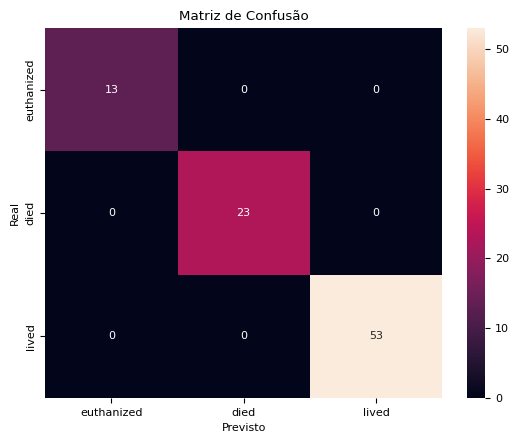

In [ ]:
plotconfmatrix(rf, X_test_scaled, y_test)

**Matriz de confusão do modelo Random Forest com oversampling**

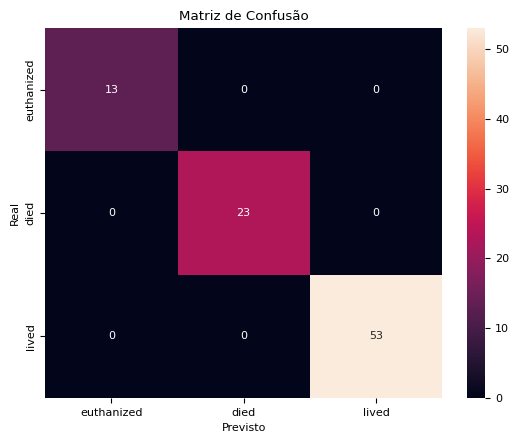

In [ ]:
plotconfmatrix(rf_osamp, X_test_scaled, y_test)

Como esperado, o modelo acertou todos os resultados na base de teste. Como a previsão usando a base de treino apresentou um erro, como mostrado a seguir, acreditamos que é possível que os modelos **rf** e **rf_osamp** talvez apresentem resultados mais realistas caso aplicados em um conjunto de testes maior.

Na dúvida se o modelo está superajustado ou não, outros 2 modelos apresentaram resultados razoavelmente satisfatórios: **svm_osamp** (SVM com oversampling) e **knn_osamp** (KNN com oversampling), ambos com F1-Score **0,88** e coeficientes Kappa **0,78** e **0,79**, respectivamente.

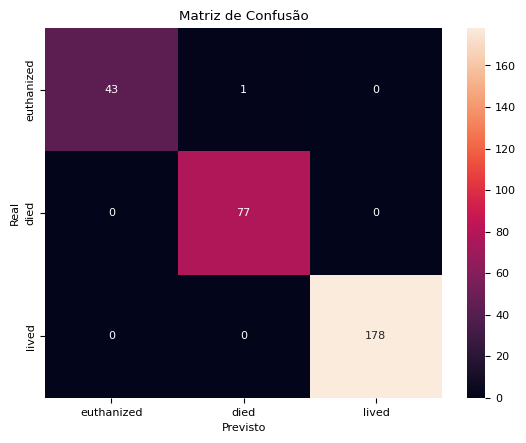

In [ ]:
# Matriz de confusão do modelo Random Forest sem balanceamento (base de treino)
plotconfmatrix(rf, X_train_scaled, y_train)

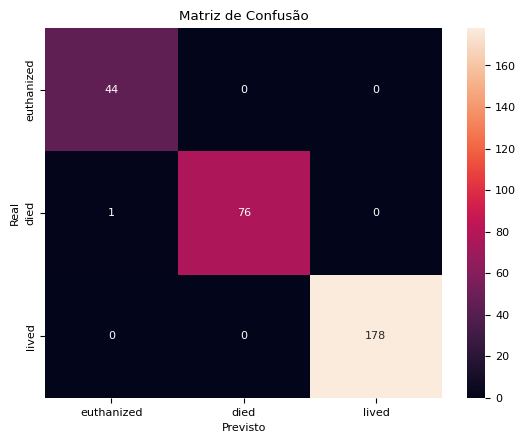

In [ ]:
# Matriz de confusão do modelo Random Forest com oversampling (base de treino)
plotconfmatrix(rf_osamp, X_train_scaled, y_train)

**Matriz de confusão do modelo KNN com** ***oversampling***

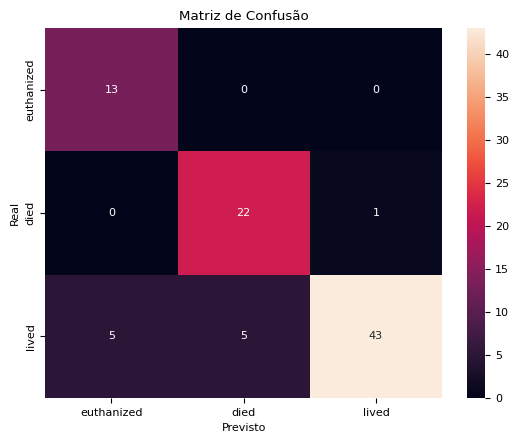

In [ ]:
plotconfmatrix(knn_osamp, X_test_scaled, y_test)

**Matriz de confusão do modelo SVM com** ***oversampling***

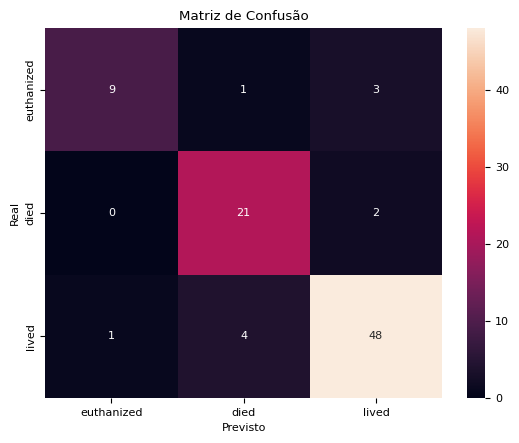

In [ ]:
plotconfmatrix(svm_osamp, X_test_scaled, y_test)

Como o pior cenário neste caso seria prever a sobrevivência do animal quando ele, na verdade, necessita de cuidados, **KNN com** ***oversampling*** (**knn_osamp**) parece ser a escolha mais segura por ter cometido menos erros neste critério.

## CONCLUSÃO

Os modelos Random Forest tiveram desempenho muito superior e não cometeram erros nas previsões feitas nos conjuntos de testes. Entretanto, não é possível afirmar com certeza de que não estejam superajustados.

\\
Alternativamente, o modelo treinado com KNN na base balanceada com oversampling pode ser uma boa opção, com poucos erros.

\\
A fim de evitar inferências incorretas, poderíamos pós-processar falso-positivos dos piores casos usando:

* Calibração de probabilidades
* Rejeição de classe
* Ensemble de modelos

Ou simplesmente indicá-los para avaliação de um especialista.

Os piores casos seriam aqueles em que o modelo prevê que o animal irá sobreviver quando, na verdade, eles morrerão ou precisarão ser submetidos à eutanásia. Uma previsão positiva desses casos poderia induzir os veterinários e tratadores a ignorarem os sinais de saúde debilitada dos animais e não os submeterem ao tratamento adequado.